![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
318288,2014,39988,0,0,0,0,0,1,0
333638,2007,38904,0,0,0,0,1,0,0
234716,2016,29607,0,0,0,0,0,1,0
208752,2014,50756,0,0,0,0,0,1,0
348892,2017,10506,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
218085,2010,84057,0,0,0,0,1,0,0
198455,2012,93770,0,1,0,0,0,0,0
205572,2010,88644,0,0,1,0,0,0,0
33541,2015,26180,0,0,0,0,0,1,0


### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [5]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [6]:
# Celda 1
import numpy as np
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [7]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [8]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [59]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=5, num_pct=10)
pred = tree_predict(X_test, tree, proba=False)
tree

{'y_pred': 1,
 'y_prob': 0.5580833214844305,
 'level': 0,
 'split': [0, 2014.0],
 'n_samples': 7031,
 'gain': 0.21062660144785156,
 'sl': {'y_pred': 0,
  'y_prob': 0.09837467921300257,
  'level': 1,
  'split': [1, 43778.0],
  'n_samples': 2336,
  'gain': 0.022527482092972617,
  'sl': {'y_pred': 0,
   'y_prob': 0.43457943925233644,
   'level': 2,
   'split': [8, 1.0],
   'n_samples': 212,
   'gain': 0.08957383525304613,
   'sl': {'y_pred': 0,
    'y_prob': 0.35638297872340424,
    'level': 3,
    'split': [1, 13558.0],
    'n_samples': 186,
    'gain': 0.07834975821754298,
    'sl': {'y_pred': 1,
     'y_prob': 0.9444444444444444,
     'level': 4,
     'split': -1,
     'n_samples': 16,
     'gain': 0},
    'sr': {'y_pred': 0,
     'y_prob': 0.29651162790697677,
     'level': 4,
     'split': [2, 1.0],
     'n_samples': 170,
     'gain': 0.04163689132942183,
     'sl': {'y_pred': 0,
      'y_prob': 0.22857142857142856,
      'level': 5,
      'split': -1,
      'n_samples': 138,
      '

In [60]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,pred)

0.8594110854503464

0.8689376443418014

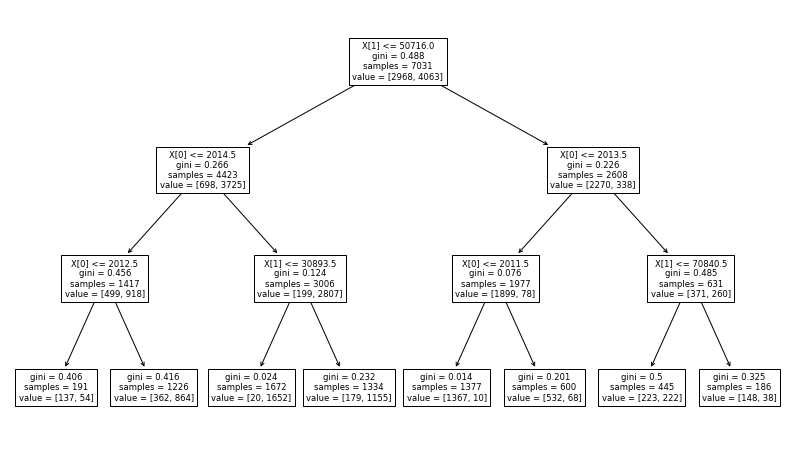

In [11]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
clf = DecisionTreeClassifier(random_state=0, max_depth=3)
clf = clf.fit(X_train,y_train)
pred = clf.predict(X_test)
from sklearn.tree import plot_tree
plt.figure(figsize=(14,8))
plot_tree(clf)
accuracy_score(y_test,pred)

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [69]:
# Celda 2
# Creación de 10 muestras de bootstrap 
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

# Construcción un árbol de decisión para cada muestra boostrap
from sklearn.tree import DecisionTreeRegressor

# Definición del modelo usando DecisionTreeRegressor de sklearn
treeclas = DecisionTreeClassifier(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train = X_train.iloc[sample]
    y_train = y_train.iloc[sample]
    treeclas.fit(X_train, y_train)
    y_pred.iloc[:,i] = treeclas.predict(X_test)

# Desempeño de cada árbol
for i in range(n_B):
    print('Árbol ', i, 'tiene un accuracy de: ', accuracy_score(y_pred.iloc[:,i], y_test))

# Predicciones promedio para cada obserbación del set de test
y_pred = y_pred.mode(axis=1)[0].astype(int)

# Accuracy al promediar las predicciones de todos los árboles
accuracy_score(y_test,y_pred)

Árbol  0 tiene un accuracy de:  0.8091801385681293
Árbol  1 tiene un accuracy de:  0.8008083140877598
Árbol  2 tiene un accuracy de:  0.8155311778290993
Árbol  3 tiene un accuracy de:  0.8247690531177829
Árbol  4 tiene un accuracy de:  0.8247690531177829
Árbol  5 tiene un accuracy de:  0.8241916859122402
Árbol  6 tiene un accuracy de:  0.8117782909930716
Árbol  7 tiene un accuracy de:  0.8241916859122402
Árbol  8 tiene un accuracy de:  0.8189953810623557
Árbol  9 tiene un accuracy de:  0.8244803695150116


0.8276558891454965

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
matrix = confusion_matrix(y_test, y_pred)
class_names = [0,1]
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
dataframe

,0,1
0,1276,162
1,537,1489


In [63]:
## Accuracy
from sklearn.metrics import precision_score
print('La exactitud en la muestra de test es:' +str(accuracy_score(y_test, y_pred)))

#Precisión
precisionTree=precision_score(y_test, y_pred)
print('La precision en la muestra de test es:' +str(precisionTree))

#
sensibilidadTree=matrix[1,1]/(matrix[1,1]+matrix[1,0])
print('La sensibilidad en la muestra de test es:' +str(sensibilidadTree))

## Especificidad

EspecificidadTree=matrix[0,0]/(matrix[0,0]+matrix[0,1])
print('La especificidad en la muestra de test es:' +str(EspecificidadTree))

La exactitud en la muestra de test es:0.7982101616628176
La precision en la muestra de test es:0.901877649909146
La sensibilidad en la muestra de test es:0.7349457058242843
La especificidad en la muestra de test es:0.8873435326842837


En la muestra test tenemos 3464 obsrvaciones de las cuales 2026 predicciones pertenecen a la clase 1 y 1438 de la clase 0

El modelo detecto 1864 casos de la clase 1 en la predicción

La matriz de confusión nos muestra que:

El modelo nos muestra que tiene una probabilidad del 78% de predecir correctamente la clase 1 y del 81% de predecir la clase 0

El modelo predice correctamente el 79% de las observaciones

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [71]:
# Celda 3
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

n_features = X_train.shape[1]
n_features = round(np.log(X_train.shape[1]),0)

bagclas = BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, max_features = np.log(n_features),
                          bootstrap=True, oob_score=True, random_state=1)
bagclas.fit(X_train, y_train)
y_pred = bagclas.predict(X_test)
accuracy_score(y_test,pred)

0.8594110854503464

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [75]:
# Celda 4
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
des_rf = accuracy_score(y_test,pred)
des_rf

0.8342956120092379

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

5

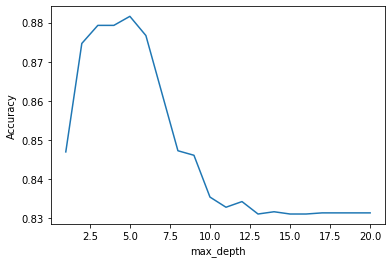

In [77]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
depth_range = range(1,21)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_depth = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for depth in depth_range:
    clf = RandomForestClassifier(max_depth=depth, random_state=1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    accuracy_scores_depth.append(accuracy_score(y_test,pred))
plt.plot(depth_range, accuracy_scores_depth)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
depth_final = sorted(zip(accuracy_scores_depth, depth_range))[::-1][0][1]
depth_final

5

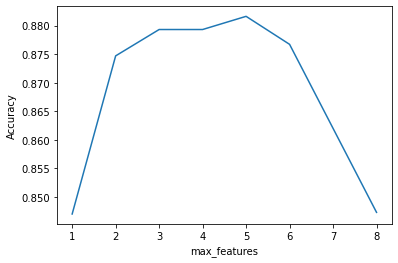

In [78]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
n_features = X_train.shape[1]

features_range = range(1,n_features)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_feat = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for depth in features_range:
    clf = RandomForestClassifier(max_depth=depth, random_state=1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    accuracy_scores_feat.append(accuracy_score(y_test,pred))
plt.plot(features_range, accuracy_scores_feat)
plt.xlabel('max_features')
plt.ylabel('Accuracy')
features_final = sorted(zip(accuracy_scores_feat, features_range))[::-1][0][1]
features_final

250

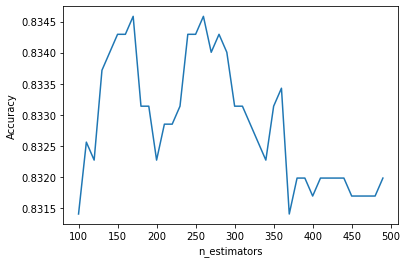

In [79]:
# Celda 5
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(100, 500, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_n = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    accuracy_scores_n.append(accuracy_score(y_test,pred))
plt.plot(estimator_range, accuracy_scores_n)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
en_final = sorted(zip(accuracy_scores_n, estimator_range))[::-1][0][1]
n_final

In [82]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf = RandomForestClassifier(n_estimators=n_final, max_features=features_final, max_depth=depth_final, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
des_rfcal = accuracy_score(y_test,pred)
des_rfcal

0.8793302540415704

Los resultados nos muestran que la profundidad máxima del árbol que garantiza el mejor desempeño es de 4. A medida que aumenta la profundidad, después de este valor el desempeño del modelo comienza a caer. 
En relación con el número de variables se observa que 4 es la cantidad que maximiza el desempeño. Del mismo modo, a medida que aumenta este número el desempeño del árbol cae.
Finalmente, ren relaci´n con el número de estimadores, el óptimo loencontramos en 250. Después de 250 observamos que el accuracy se reduce significativamente.

Al entrenar el modelo con estos parámetros ya calibrados encontramos que mejora significativamente el desempeño con relación al modelo del punto 4 en donde obtuvimos un desempeño del 83.7

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [45]:
# Celda 6
!pip install xgboost
from xgboost import XGBClassifier
clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
des_xg = accuracy_score(y_pred, y_test)
des_xg

[10:39:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8438221709006929

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

0

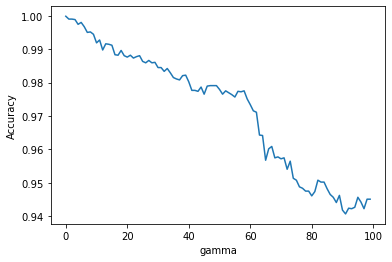

In [95]:
# Celda 7
from sklearn.model_selection import cross_val_score
gamma_range = range(0, 100)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_gamma = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for dato in gamma_range:
    clf = XGBClassifier(gamma = dato)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    accuracy_scores_gamma.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
plt.plot(gamma_range, accuracy_scores_gamma)
plt.xlabel('gamma')
plt.ylabel('Accuracy')
gamma_final = sorted(zip(accuracy_scores_gamma, gamma_range))[::-1][0][1]
gamma_final

0.9

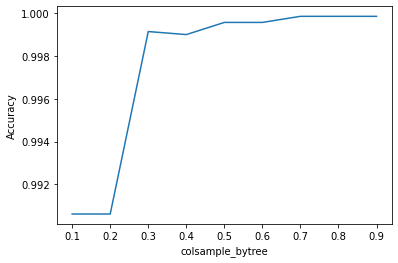

In [96]:
colsample_bytree = np.arange(0.1,1.0,0.1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_col = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for sample in colsample_bytree:
    clf = XGBClassifier(colsample_bytree = sample, verbosity=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    accuracy_scores_col.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
plt.plot(colsample_bytree, accuracy_scores_col)
plt.xlabel('colsample_bytree')
plt.ylabel('Accuracy')
col_final = sorted(zip(accuracy_scores_col, colsample_bytree))[::-1][0][1]
col_final

0.9

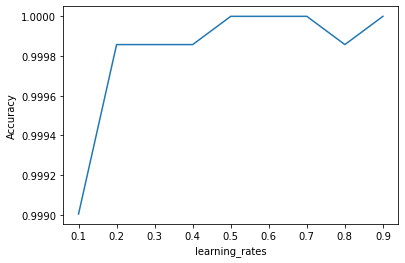

In [97]:
learning_rates = np.arange(0.1,1.0,0.1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_learning = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for rate in learning_rates:
    clf = XGBClassifier(learning_rate = rate, verbosity=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    accuracy_scores_learning.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
plt.plot(learning_rates, accuracy_scores_learning)
plt.xlabel('learning_rates')
plt.ylabel('Accuracy')
lr_final = sorted(zip(accuracy_scores_learning, learning_rates))[::-1][0][1]
lr_final

In [98]:
# Celda 6
!pip install xgboost
from xgboost import XGBClassifier
clf = XGBClassifier(gamma = gamma_final, colsample_bytree = col_final, learning_rate= lr_final)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
des_xg2 = accuracy_score(y_pred, y_test)
des_xg2

0.8438221709006929

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8

